In [1]:
import geopandas as gpd
import libpysal as lps
import pandas as pd
import numpy as np

from geosnap import DataStore
from geosnap.io import get_acs

/Users/knaaptime/mambaforge/envs/seg_networks/lib/python3.9/site-packages/geosnap/_data.py:66: UserWarning: The geosnap data storage class is provided for convenience only. The geosnap developers make no promises regarding data quality, consistency, or availability, nor are they responsible for any use/misuse of the data. The end-user is responsible for any and all analyses or applications created with the package.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
la = get_acs(DataStore(), msa_fips='31080', years=[2017], level='tract')

/Users/knaaptime/mambaforge/envs/seg_networks/lib/python3.9/site-packages/geosnap/_data.py:66: UserWarning: The geosnap data storage class is provided for convenience only. The geosnap developers make no promises regarding data quality, consistency, or availability, nor are they responsible for any use/misuse of the data. The end-user is responsible for any and all analyses or applications created with the package.
  warn(


In [33]:
la.shape

(2929, 157)

<AxesSubplot:>

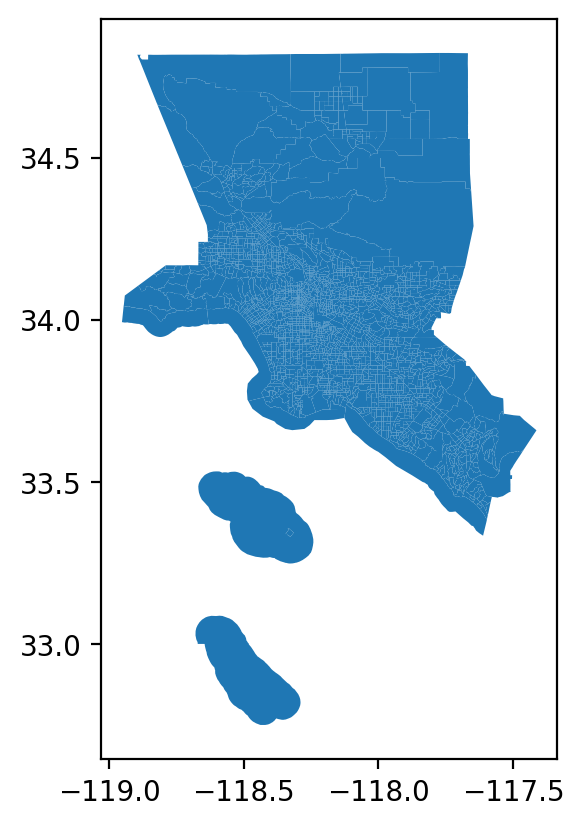

In [3]:
la.plot()

In [5]:
example_geoid = '06037101110'

In [6]:
lps.weights.Queen.from_dataframe?

Signature: lps.weights.Queen.from_dataframe(df, geom_col=None, **kwargs)
Docstring:
Construct a weights object from a pandas dataframe with a geometry
column. This will cast the polygons to PySAL polygons, then build the W
using ids from the dataframe.

Parameters
----------
df          : DataFrame
              a :class: `pandas.DataFrame` containing geometries to use
              for spatial weights
geom_col    : string
              the name of the column in `df` that contains the
              geometries. Defaults to active geometry column
idVariable  : string
              the name of the column to use as IDs. If nothing is
              provided, the dataframe index is used
ids         : list
              a list of ids to use to index the spatial weights object.
              Order is not respected from this list.
id_order    : list
              an ordered list of ids to use to index the spatial weights
              object. If used, the resulting weights object will iterate
 

In [7]:
laq = lps.weights.Queen.from_dataframe(la, idVariable='geoid')

/Users/knaaptime/mambaforge/envs/seg_networks/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [8]:
import pandana as pdna

In [9]:
la_net = pdna.Network.from_hdf5("../../../geosnap_data/metro_networks_8k/31080.h5")

Generating contraction hierarchies with 10 threads.
Setting CH node vector of size 734018
Setting CH edge vector of size 1133541
Range graph removed 247594 edges of 2267082
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [37]:
la_net.edges_df.shape

(1133541, 3)

### Create network shortest distance matrix

In [10]:
from geosnap.analyze import compute_travel_cost_adjlist

In [11]:
compute_travel_cost_adjlist?

Signature:
compute_travel_cost_adjlist(
    origins,
    destinations,
    network,
    index_orig=None,
    index_dest=None,
)
Docstring:
Generate travel cost adjacency list.

Parameters
----------
origins : geopandas.GeoDataFrame
    a geodataframe containing the locations of origin features
destinations : geopandas.GeoDataFrame
    a geodataframe containing the locations of destination features
network : pandana.Network
    pandana Network instance for calculating the shortest path between origins and destinations
index_orig : str, optional
    Column on the origins dataframe the defines unique units to be used as the origins id
    on the resulting dataframe. If not set, each unit will be assigned the index from its
    associated node_id on the network
index_dest : str, optional
    Column on the destinations dataframe the defines unique units to be used as the destinations id
    on the resulting dataframe. If not set, each unit will be assigned the index from its
    associated 

In [ ]:
la_net_dist = compute_travel_cost_adjlist(la,la, la_net)

,origin,destination,cost
0,0,0,0.000
1,0,1,1407.220
2,0,2,843.149
3,0,3,1746.145
4,0,4,2879.125
...,...,...,...
2924,2928,2924,43122.795
2925,2928,2925,43707.363
2926,2928,2926,44273.168
2927,2928,2927,4294967.295


In [18]:
# use the W machinery to convert to a distance matrix
la_net_w = lps.weights.W.from_adjlist(la_net_dist, 'origin', 'destination', 'cost')

In [79]:
la_net_w

In [24]:
la_net_w.sparse

<2929x2929 sparse matrix of type '<class 'numpy.float64'>'
	with 8576112 stored elements in Compressed Sparse Row format>

In [26]:
from scipy.sparse import save_npz, load_npz

In [31]:
# save the network shortest path matrix to avoid recomputation
save_npz('../../data/la_net_dist.npz', la_net_w.sparse)

In [32]:
qfile = load_npz('../../data/la_net_dist.npz')

In [34]:
laq_roundtrip = lps.weights.WSP(qfile).to_W()

In [50]:
from sklearn.metrics import pairwise_distances, euclidean_distances

In [81]:
la_net_w.full()[0].round(3).mean()

103111.1010955115

In [61]:
# both distances should be in meters now
la = la.to_crs(la.estimate_utm_crs())

In [110]:
# dataframe of pairwise distances between centroids in euclidean meters
euc_diffs = pd.DataFrame(euclidean_distances(
        pd.DataFrame({"x": la.centroid.x.values, "y": la.centroid.y.values})
    ))

In [111]:
euc_diffs

,0,1,2,3,4,5,6,7,8,9,...,2919,2920,2921,2922,2923,2924,2925,2926,2927,2928
0,0.000000,951.340303,750.340282,1361.653215,2347.045059,1846.540506,6806.069313,6808.036665,7558.274094,4650.914801,...,52889.091099,53985.588745,50824.154198,51403.398959,50224.843895,51049.328505,50041.834510,50287.780290,60685.631106,90094.577703
1,951.340303,0.000000,1636.574355,1951.378643,2743.166347,2782.722443,7559.861763,7652.441813,8414.553112,5343.981958,...,53535.631273,54642.813005,51481.482160,52037.764718,50835.376472,51645.559287,50681.471939,50914.979769,61291.630588,90795.639540
2,750.340282,1636.574355,0.000000,851.393105,1875.971720,1165.979241,6612.879175,6480.588225,7205.226735,4569.436342,...,52166.542897,53259.935718,50098.569047,50684.563191,49513.686473,50342.982867,49321.443769,49571.220692,59975.581219,89357.401287
3,1361.653215,1951.378643,851.393105,0.000000,1028.628409,1508.073187,7301.742211,7066.033721,7760.934722,5336.883371,...,51600.062705,52703.630184,49542.207577,50106.804039,48914.919759,49732.314659,48748.408305,48986.962252,59373.612705,88846.440828
4,2347.045059,2743.166347,1875.971720,1028.628409,0.000000,2232.070034,8100.475325,7747.632161,8401.663411,6239.867432,...,50829.252481,51943.697289,48782.780424,49324.026957,48109.713123,48914.245883,47970.992188,48197.357901,58563.547091,88132.173570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924,51049.328505,51645.559287,50342.982867,49732.314659,48914.245883,49628.056176,51686.683813,50413.616125,50154.537395,51958.304491,...,4100.782661,5392.913569,4382.505736,2734.730824,1284.172523,0.000000,3207.796393,2291.739815,9669.858111,40429.854128
2925,50041.834510,50681.471939,49321.443769,48748.408305,47970.992188,48551.430289,50281.629874,49005.679282,48704.092373,50680.932211,...,2895.981315,4167.660402,1513.304161,1411.295404,2054.469005,3207.796393,0.000000,916.501263,10938.937253,40552.611166
2926,50287.780290,50914.979769,49571.220692,48986.962252,48197.357901,48817.025616,50644.373070,49368.837670,49079.698431,51006.209902,...,2972.275687,4337.851798,2252.995376,1231.942153,1168.627271,2291.739815,916.501263,0.000000,10513.922896,40515.762565
2927,60685.631106,61291.630588,59975.581219,59373.612705,58563.547091,59245.086451,61154.707579,59879.361825,59592.870543,61497.082301,...,8419.003526,7857.536150,10630.401390,9527.781244,10464.404160,9669.858111,10938.937253,10513.922896,0.000000,31184.036784


In [112]:
# dataframe of pairwise distances between centroids in network meters
net_diffs = pd.DataFrame(la_net_w.full()[0])

In [152]:
net_dist_2k = net_diffs[net_diffs<2000]

In [154]:
euc_dist_2k = euc_diffs[euc_diffs<2000]

<AxesSubplot:>

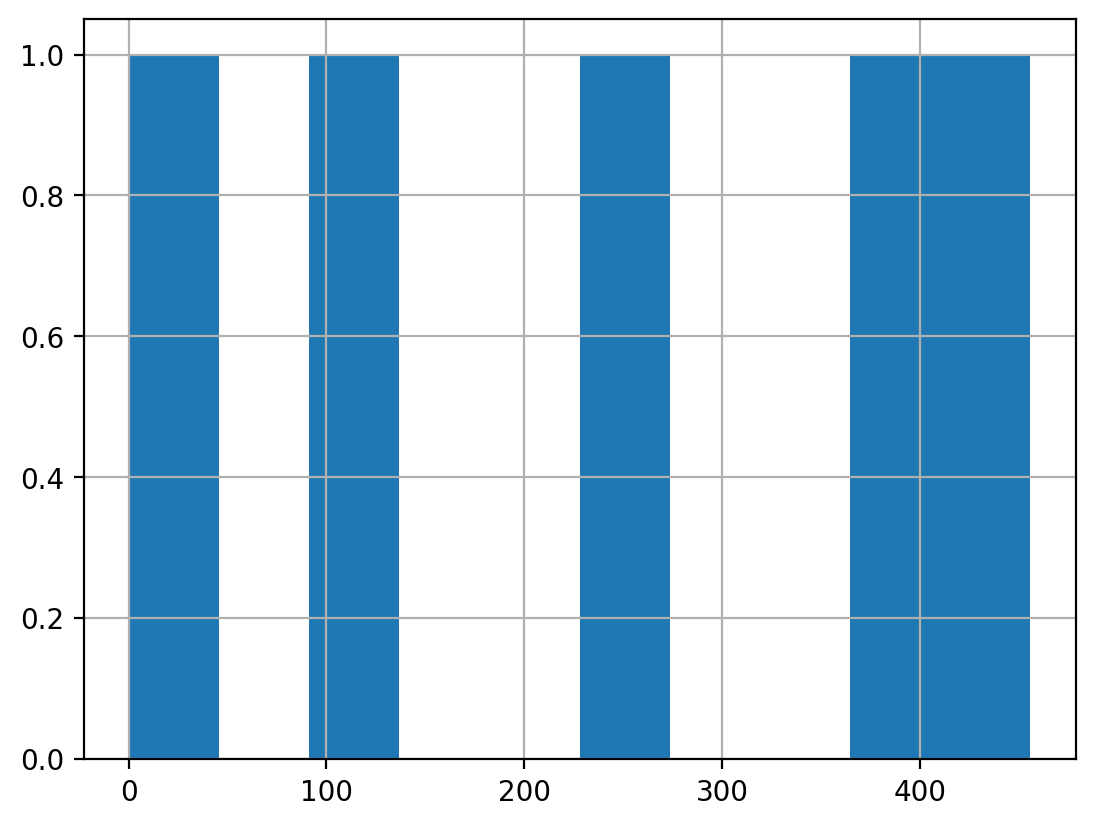

In [157]:
(net_dist_2k - euc_dist_2k.round(3))[0].hist()


<AxesSubplot:ylabel='Density'>

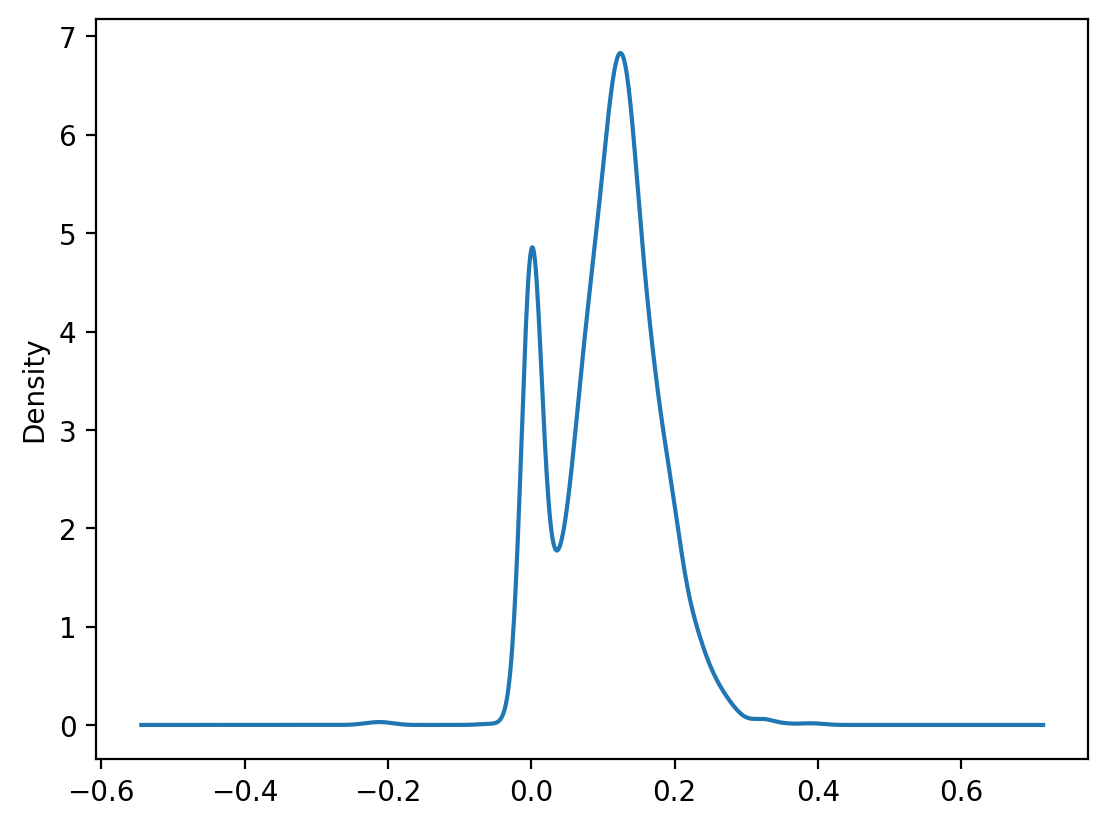

In [170]:
# pairwise difference between metrics
((net_dist_2k - euc_dist_2k).round(3)/2000).median().plot(kind='kde')

<AxesSubplot:>

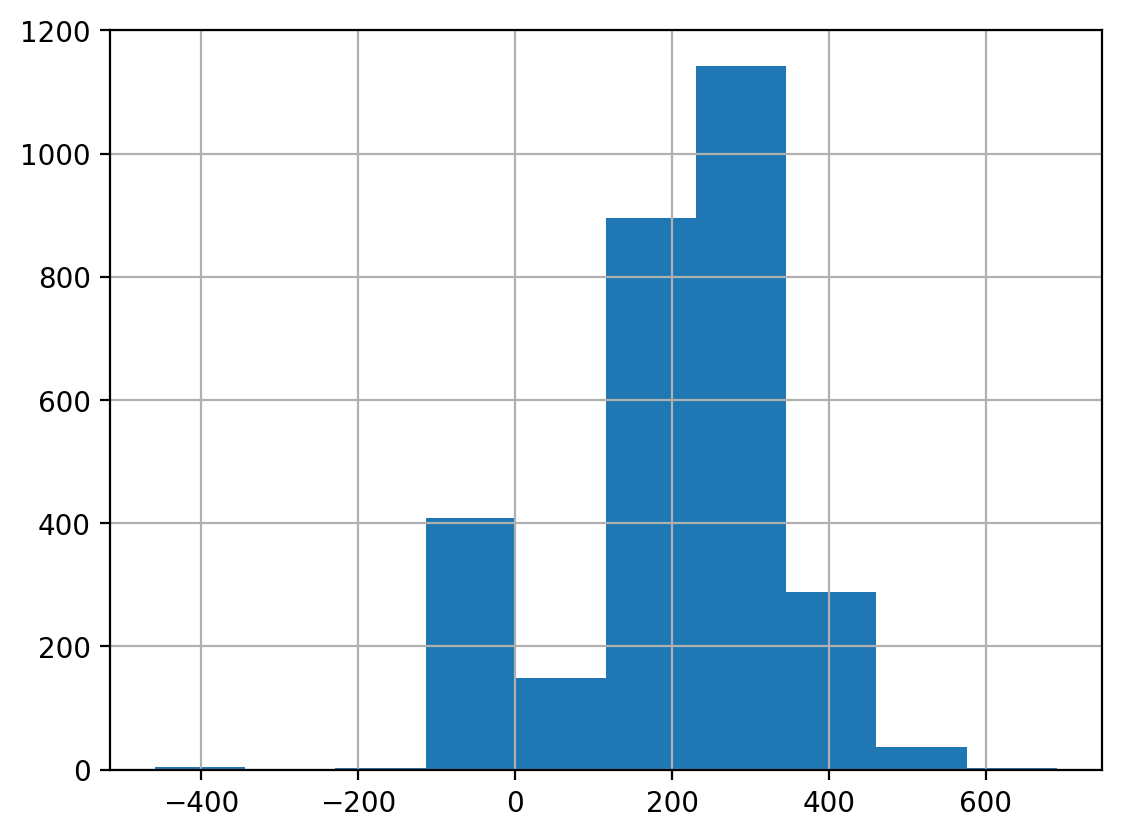

In [180]:
(net_dist_2k - euc_dist_2k).round(3).mean(axis=1).hist()

In [176]:
(2000 - (net_dist_2k - euc_dist_2k).round(3) /2000).mean()

0       1999.881760
1       1999.999864
2       1999.924673
3       1999.898337
4       1999.958173
           ...     
2924    1999.890295
2925    1999.812879
2926    1999.779531
2927    2000.000000
2928    2000.000000
Length: 2929, dtype: float64

In [127]:
diff_df = (net_diffs - euc_diffs).round(3)

In [ ]:
np.log(diff_df).dropna().plot(kind='kde')

<AxesSubplot:>

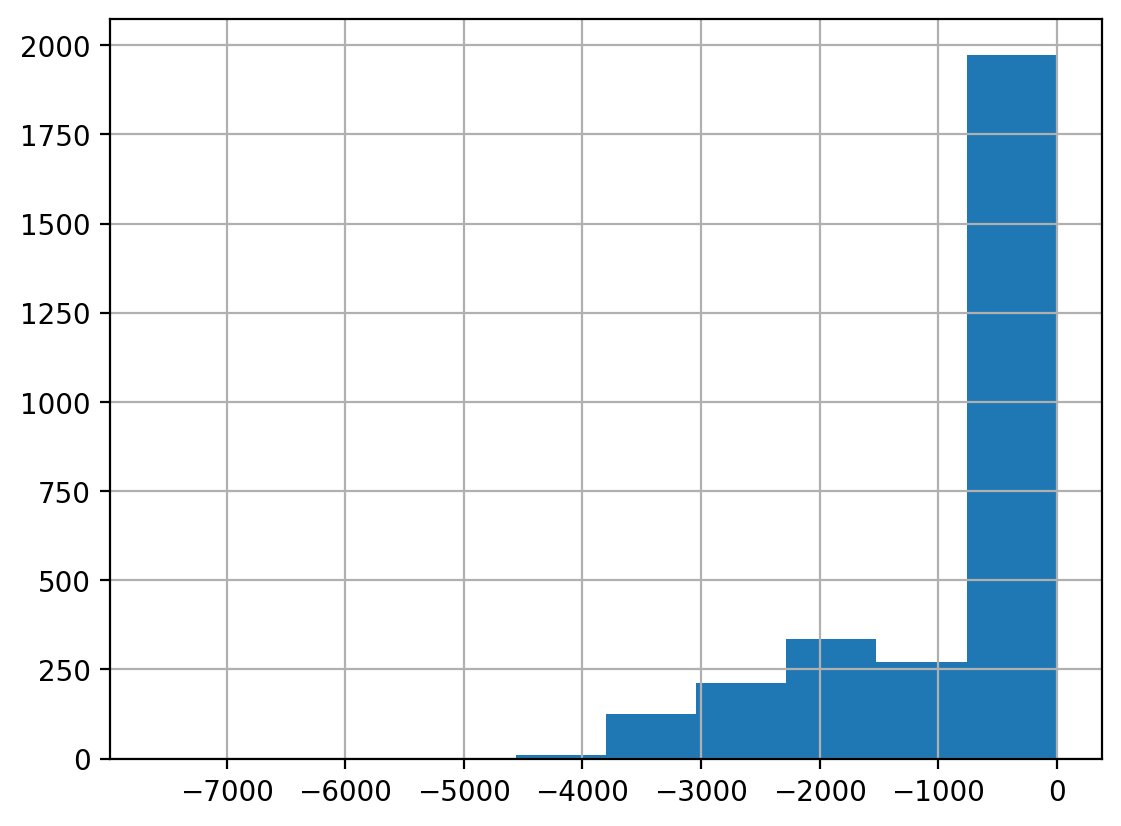

In [145]:
diff_df.min().hist()

In [140]:
np.log(diff_df[0]).median()

8.68858152755756

In [143]:
np.log(diff_df).median().median()

8.447240788297444